In [1]:
import numpy as np
import process_edited as pce
#import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
import numpy as np

In [2]:
os.getcwd()

'c:\\Users\\namjo\\OneDrive\\문서\\GitHub\\AutoDiffusion\\Codes + Descriptions'

In [3]:
#strings_set = {'abalone', 'adult', 'Churn_Modelling','faults', 'indian_liver_patient', 
#               'insurance', 'News', 'Obesity', 'Shoppers', 'Titanic', 'wilt', 'Bean', 'nursery', 'Magic', 'HTRU'}
strings_set = {'HTRU'}
Model = 'AutoDiff'

for string in strings_set:
    # Change the directory to where you stored your data.
    filename = f'C:/Users/namjo/OneDrive/문서/GitHub/AutoDiffusion/Real-data/Real-data/{string}.csv'
    # Read dataframe
    print(filename)
    real_df = pd.read_csv(filename)
    
    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_df, threshold)

    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_epochs = 15000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = 50

    ds = ae.train_autoencoder(real_df, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    ################################################################################################################
    # diffusion hyper-parameters
    diff_n_epochs = 10000 #@param {'type':'integer'}
    hidden_dims = (256, 1024, 256) #@param {type:"raw"}
    converted_table_dim = latent_features.shape[1] #@param {'type':'integer'}
    sigma = 20  #@param {'type':'integer'} 
    num_batches_per_epoch = 50 #@param {'type':'number'}
    batch_size = 50 #@param {'type':'integer'}
    T = 100  #@param {'type':'integer'}

    score = TabDiff.train_diffusion(latent_features, T, eps, sigma, lr, \
                        num_batches_per_epoch, maximum_learning_rate, weight_decay, diff_n_epochs, batch_size)

    ################################################################################################################
    # Generate 10 fake tabular datasets
    T = 300; N = latent_features.shape[0]; P = latent_features.shape[1]
    
    sample = diff.Euler_Maruyama_sampling(score, T, N, P, device)
    gen_output = ds[0](sample.to(device), ds[2].to(device), ds[3].to(device))
    syn_df = pce.convert_to_table(real_df, gen_output, threshold)


C:/Users/namjo/OneDrive/문서/GitHub/AutoDiffusion/Real-data/Real-data/HTRU.csv


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

c:\Users\namjo\OneDrive\문서\GitHub\AutoDiffusion\Codes + Descriptions\diffusion.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)  # Ensure 't' is on the same device as 'x'


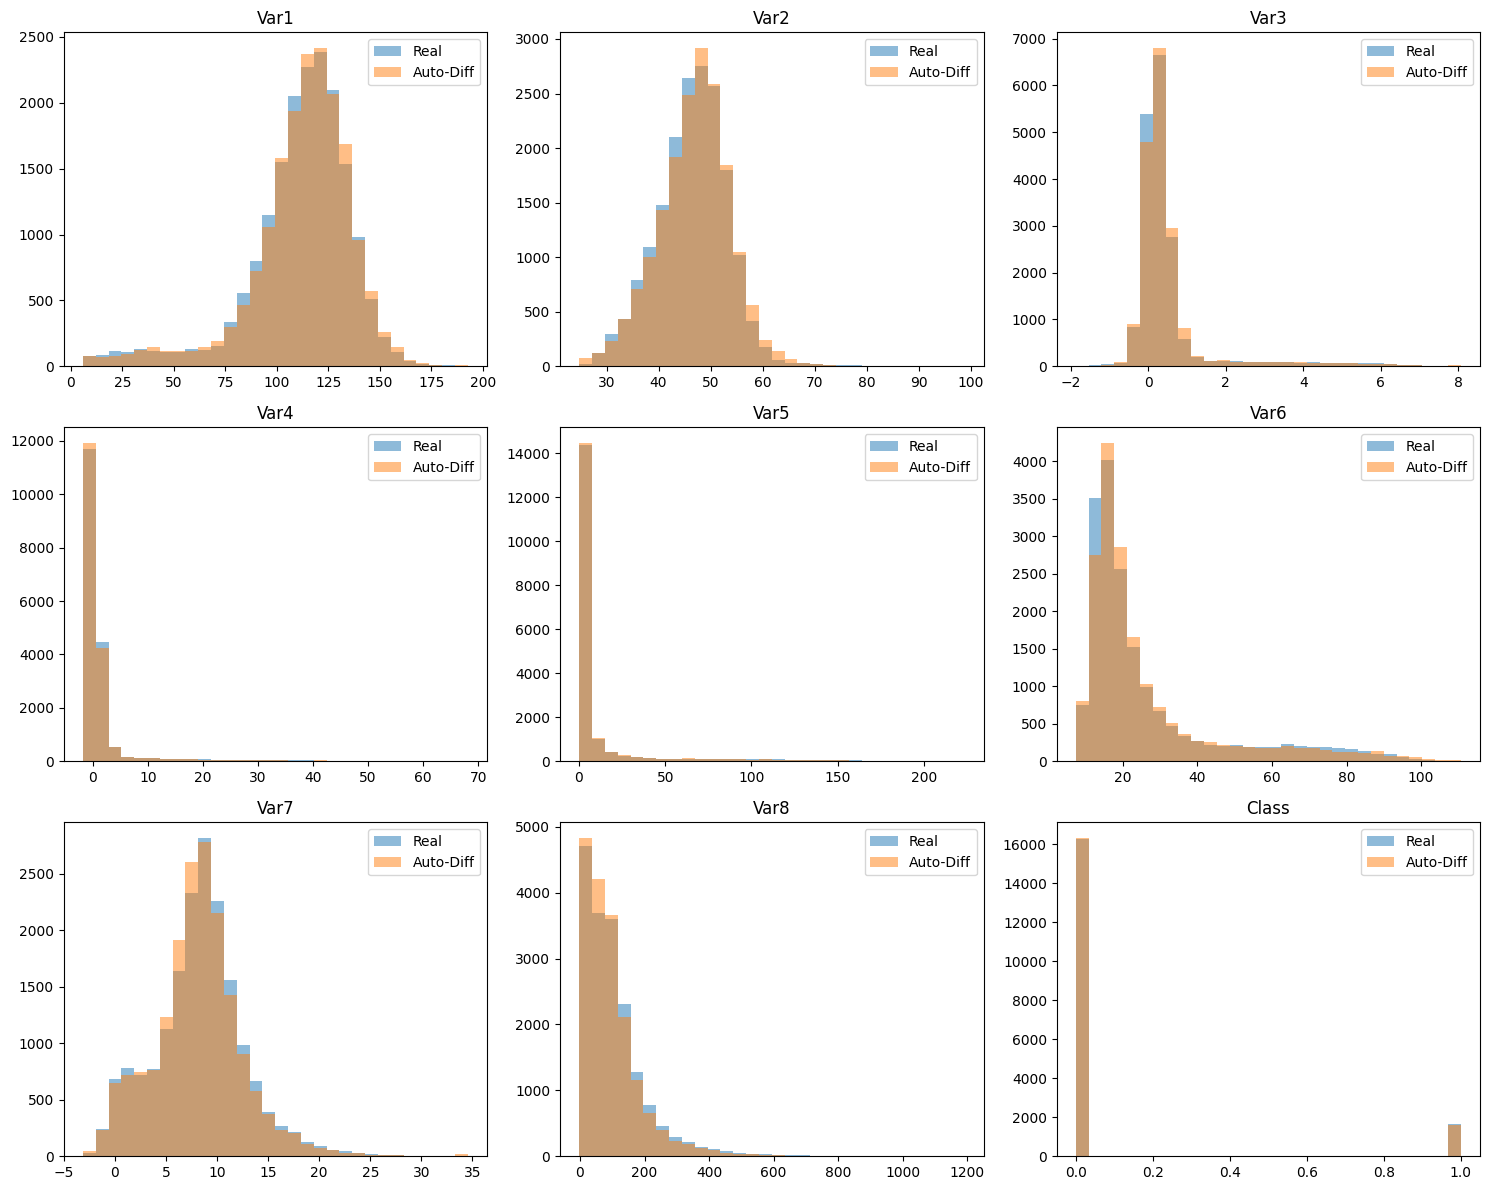

In [12]:
import math
import matplotlib.pyplot as plt

# Suppose you have two DataFrames:
#   real_df: the real dataset
#   syn_df:  the synthetic dataset (Auto-Diff)

columns = real_df.columns  # or a subset of columns if you wish
n = len(columns)

# Choose how many subplots you want in each row
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))

# In case nrows or ncols is 1, turn 'axes' into a 2D array for consistent indexing
if nrows == 1 and ncols == 1:
    axes = [[axes]]
elif nrows == 1:
    axes = [axes]
elif ncols == 1:
    axes = [[ax] for ax in axes]

for idx, col in enumerate(columns):
    row = idx // ncols
    col_ind = idx % ncols
    
    # Plot real data
    axes[row][col_ind].hist(
        real_df[col], bins=30, alpha=0.5, label='Real'
    )
    
    # Plot synthetic data
    axes[row][col_ind].hist(
        syn_df[col], bins=30, alpha=0.5, label='Auto-Diff'
    )
    
    axes[row][col_ind].set_title(col)
    axes[row][col_ind].legend()

# If there are empty subplots (when the total number of columns is not a multiple of ncols),
# we'll turn them off.
for j in range(idx+1, nrows*ncols):
    row = j // ncols
    col_ind = j % ncols
    axes[row][col_ind].axis('off')

plt.tight_layout()
plt.show()
